# Example Notebook to showcasing how we interact with JTReaders

In [1]:
# First change dir to Jack parent
import os
os.chdir('..')

In [2]:
# Configure Jack logger to print to standard output, that is console
import sys, os
import logging
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
logger = logging.getLogger(os.path.basename(sys.argv[0]))

### Bookkeeping of all existing readers: `readers.py`

In [3]:
import jtr.jack.readers as readers
print("Existing models:\n{}".format(", ".join(readers.readers.keys())))

Existing models:
example_reader, modelf_reader, snli_reader, fastqa_reader


### Load test data

In [4]:
# Loaded some test data to work on
# This loads train, dev, and test data of sizes (2k, 1k, 1k)
from jtr.jack.core import load_labelled_data


class TestDatasets(object):
    @staticmethod
    def generate_SNLI():
        snli_path, snli_data = 'tests/test_data/SNLI/', []
        splits = ['train.json', 'dev.json', 'test.json']
        for split in splits:
            path = os.path.join(snli_path, split)
            snli_data.append(load_labelled_data(path))

        return snli_data

train_set, dev_set, test_set = TestDatasets.generate_SNLI()

### Create a reader

In [5]:
from jtr.preprocess.vocab import Vocab
# Create example reader with a basic config
embedding_dim = 128
hidden_dim = 128
config = {"batch_size": 128, "repr_dim": hidden_dim, "repr_dim_input": embedding_dim, 'dropout' : 0.1}
reader = readers.readers["snli_reader"](Vocab(), config)

### Add hooks

In [6]:
# We create hooks which keep track of the metrics such as the loss
# We also create a classification metric monitoring hook for our model
from jtr.jack.train.hooks import LossHook
hooks = [LossHook(reader, iter_interval=10),
         readers.eval_hooks['snli_reader'](reader, dev_set, iter_interval=25)]

### Initialise optimiser

In [7]:
# Here we initialise our optimiser
# we choose Adam with standard momentum values and learning rate 0.001
import tensorflow as tf
learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate)

### Train reader

In [8]:
# Lets train the reader on the CPU for 2 epochs
reader.train(optimizer, train_set,
             hooks=hooks, max_epochs=2,
             device='/cpu:0')

INFO:root:Setting up data and model...
INFO:root:Start training...
INFO:jtr.jack.train.hooks:Epoch 1	Iter 10	Loss 1.1055793643
INFO:jtr.jack.train.hooks:Epoch 1	Iter 20	Loss 1.1087624073
INFO:jtr.jack.train.hooks:Started evaluation ClassificationEvalHook


/usr/local/lib/python3.4/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


INFO:jtr.jack.train.hooks:Epoch 1	Iter 25	total 1000	Accuracy: 0.336	F1_macro: 0.217	ClassificationEvalHook
INFO:jtr.jack.train.hooks:Epoch 1	Iter 30	Loss 1.10379798412
INFO:jtr.jack.train.hooks:Epoch 1	Iter 40	Loss 1.10415589809
INFO:jtr.jack.train.hooks:Epoch 1	Iter 50	Loss 1.1075956583
INFO:jtr.jack.train.hooks:Started evaluation ClassificationEvalHook
INFO:jtr.jack.train.hooks:Epoch 1	Iter 50	total 1000	Accuracy: 0.358	F1_macro: 0.288	ClassificationEvalHook
INFO:jtr.jack.train.hooks:Epoch 1	Iter 60	Loss 1.11435104609
INFO:jtr.jack.train.hooks:Started evaluation ClassificationEvalHook
INFO:jtr.jack.train.hooks:Epoch 1	Iter 62	total 1000	Accuracy: 0.418	F1_macro: 0.330	ClassificationEvalHook
INFO:jtr.jack.train.hooks:Epoch 2	Iter 70	Loss 1.08942351341
INFO:jtr.jack.train.hooks:Started evaluation ClassificationEvalHook
INFO:jtr.jack.train.hooks:Epoch 2	Iter 75	total 1000	Accuracy: 0.409	F1_macro: 0.317	ClassificationEvalHook
INFO:jtr.jack.train.hooks:Epoch 2	Iter 80	Loss 1.08438639641

### Plotting the results

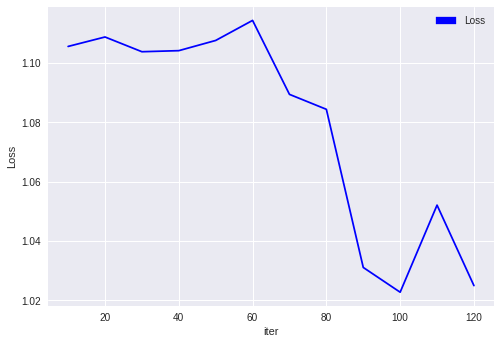

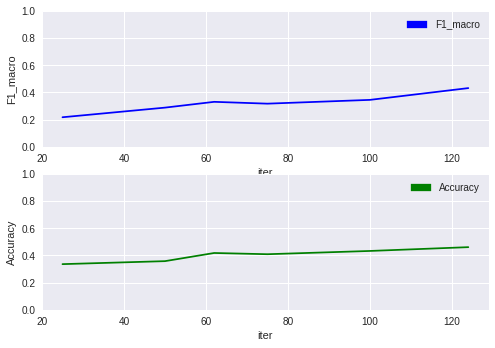

In [9]:
# This plots the loss
hooks[0].plot()
# This plots the F1 (macro) score and accuracy between 0 and 1
hooks[1].plot(ylim=[0.0, 1.0])

### Analysing errors

In [12]:
# We can analyse what our model is doing by using the MisclassificationAnalyzerOutputModule.
from jtr.jack.tasks.mcqa.simple_mcqa import MisclassificationOutputModule   

# We want misclassifications where the model predicted a probability between 0 and 0.2, 
# and we want to print 10 examples
reader.output_module = MisclassificationOutputModule(interval=[0.0, 0.20], limit=10)                                                                                                                     
reader.process_outputs(test_set) # run the output module on the test set
# From the output below we can see that our model still has problems to distinguishe between neutral and
# entailment between premise and hypothesis

###########################################################################
Question: People are standing on a sidewalk.
Support: Pedestrians are gazing at a display of books set out on a sidewalk under a tree.
Answer: neutral
---------------------------------------------------------------------------
Predicted class: entailment
Predictions: [('neutral', 0.14441958), ('contradiction', 0.1962076), ('entailment', 0.65937281)]
###########################################################################

###########################################################################
Question: The two boys are swimming with their floats
Support: The two boys are swimming with boogie boards.
Answer: entailment
---------------------------------------------------------------------------
Predicted class: contradiction
Predictions: [('neutral', 0.43387231), ('contradiction', 0.43737411), ('entailment', 0.12875359)]
###########################################################################

#########